In [1]:
! gdown https://drive.google.com/u/3/uc?id=1holFbETG4H41uD3OfFe6n5by-d2Gs8FH

Downloading...
From: https://drive.google.com/u/3/uc?id=1holFbETG4H41uD3OfFe6n5by-d2Gs8FH
To: /content/classification_data.zip
84.3MB [00:01, 52.1MB/s]


In [2]:
! unzip -qq classification_data.zip

In [3]:
! gdown https://drive.google.com/u/3/uc?id=1mjEJWpfhwtvnN7O7ZzP8dDSPjDeXY1Yy

Downloading...
From: https://drive.google.com/u/3/uc?id=1mjEJWpfhwtvnN7O7ZzP8dDSPjDeXY1Yy
To: /content/PBC_8_DA.zip
232MB [00:02, 85.1MB/s]


In [4]:
! unzip -qq PBC_8_DA.zip

In [5]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import glob
import time
import cv2
import os
from tensorflow.keras.utils import to_categorical
from PIL import Image

import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D,\
                                    GlobalMaxPool2D, Dropout, SpatialDropout2D, add, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall, SensitivityAtSpecificity, PrecisionAtRecall, \
                                     TruePositives, TrueNegatives, FalsePositives, FalseNegatives


from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import glob
import time
import cv2
import os

In [6]:
# Source Domain = Smear Slide, Target Domain = PBC dataset

In [6]:
dir = glob.glob('classification_data/*')
get_freq = {}
# count = 1
for item in dir:
  freq = len(glob.glob("{}/*".format(item)))
  print(freq)
  item_name  = item.split('/')[1]
  get_freq[item_name] = freq

56
73
116
62
55
32
93
54
28
125


In [7]:
short_index = []

for item in dir:
  name = item.split('/')[1]
  if ' ' in name:
      print(name)
      name = name.split(' ')[0] +"_"+ name.split(' ')[1]
  short_name = name
  short_index.append(short_name)

print(short_index)

['promyelocyte', 'myelocyte', 'neutrophil', 'lymphocyte', 'band', 'metamyelocyte', 'eosinophil', 'monocyte', 'basophil', 'blast']


In [8]:


count = 0
short_rev_index = {}
for item in short_index:
  short_rev_index[item] = count
  count += 1
# print(short_rev_index)

index = {}
rev_index = {}
count = 0
for item in get_freq:
  index[item] = count
  rev_index[count] = item
  count += 1 
print(index)
print(rev_index)

{'promyelocyte': 0, 'myelocyte': 1, 'neutrophil': 2, 'lymphocyte': 3, 'band': 4, 'metamyelocyte': 5, 'eosinophil': 6, 'monocyte': 7, 'basophil': 8, 'blast': 9}
{0: 'promyelocyte', 1: 'myelocyte', 2: 'neutrophil', 3: 'lymphocyte', 4: 'band', 5: 'metamyelocyte', 6: 'eosinophil', 7: 'monocyte', 8: 'basophil', 9: 'blast'}


In [9]:
def parse_filepath(filepath):
    try:
        label = filepath.split('/')[1]
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [10]:

DATA_DIR = 'classification_data'  # 302410 images. validate accuracy: 98.8%
H, W, C = 100, 100, 3
N_LABELS = len(index)
D = 1

files = glob.glob("{}/*/*.jpg".format(DATA_DIR))
print("Total files = ",len(files))


# create a pandas data frame of images, age, gender and race
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.tail()

Total files =  694


,label,file
689,blast,classification_data/blast/IMG_3540_2.jpg
690,blast,classification_data/blast/IMG_3538_3.jpg
691,blast,classification_data/blast/IMG_2834_4.jpg
692,blast,classification_data/blast/IMG_3648_2.jpg
693,blast,classification_data/blast/IMG_2835_2.jpg


In [11]:

np.random.seed(42)
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.80)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.80)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 444, valid count: 111, test count: 139


In [12]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tqdm import tqdm

def get_data_generator(df, indices):
  images, labels = [], []
  for i in tqdm(indices):
    r = df.iloc[i]
    file, label = r['file'], r['label']
    im = Image.open(file)
    im = im.resize((H, W))
    im = np.array(im) / 255.0
    images.append(im)
    labels.append(index[label])
  return np.array(images), np.array(labels)


In [13]:
x_source_train,  y_source_train = get_data_generator(df, train_idx)
print(x_source_train.shape, y_source_train.shape)

100%|██████████| 444/444 [00:08<00:00, 55.14it/s]

(444, 100, 100, 3) (444,)


In [14]:
x_source_val,  y_source_val = get_data_generator(df, valid_idx)
print(x_source_val.shape, y_source_val.shape)

100%|██████████| 111/111 [00:01<00:00, 57.64it/s]

(111, 100, 100, 3) (111,)


In [15]:
x_source_test,  y_source_test = get_data_generator(df, test_idx)
print(x_source_test.shape, y_source_test.shape)

100%|██████████| 139/139 [00:02<00:00, 53.93it/s]

(139, 100, 100, 3) (139,)


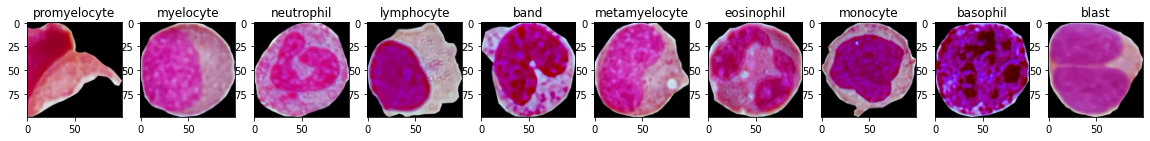

In [17]:
plt.figure(figsize=(20, 15))
for i, digit in enumerate(np.unique(y_source_train), start=1):
    index_1 = np.where(y_source_train == digit)[0][0]
    ax = plt.subplot(1, 10, i)
    ax.imshow(x_source_train[index_1])
    ax.set_title(rev_index[digit])

In [18]:
dir = glob.glob('PBC_8_DA/*')
get_freq = {}
# count = 1
for item in dir:
  freq = len(glob.glob("{}/*".format(item)))
  print(freq)
  item_name  = item.split('/')[1]
  get_freq[item_name] = freq

592
1137
3329
1214
1015
3117
1420
1218


In [19]:

DATA_DIR = 'PBC_8_DA'  # 302410 images. validate accuracy: 98.8%
H, W, C = 100, 100, 3
N_LABELS = len(index)
D = 1

files = glob.glob("{}/*/*.jpg".format(DATA_DIR))
print("Total files = ",len(files))


# create a pandas data frame of images, age, gender and race
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.tail()

Total files =  13042


,label,file
13037,basophil,PBC_8_DA/basophil/850.jpg
13038,basophil,PBC_8_DA/basophil/146.jpg
13039,basophil,PBC_8_DA/basophil/476.jpg
13040,basophil,PBC_8_DA/basophil/66.jpg
13041,basophil,PBC_8_DA/basophil/143.jpg


In [20]:

np.random.seed(42)
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.80)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.80)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 8346, valid count: 2087, test count: 2609


In [21]:
x_target_train,  y_target_train = get_data_generator(df, train_idx)
print(x_target_train.shape, y_target_train.shape)

100%|██████████| 8346/8346 [00:16<00:00, 515.70it/s]


(8346, 100, 100, 3) (8346,)


In [22]:
x_target_val,  y_target_val = get_data_generator(df, valid_idx)
print(x_target_val.shape, y_target_val.shape)

100%|██████████| 2087/2087 [00:03<00:00, 532.25it/s]


(2087, 100, 100, 3) (2087,)


In [23]:
x_target_test,  y_target_test = get_data_generator(df, test_idx)
print(x_target_test.shape, y_target_test.shape)

100%|██████████| 2609/2609 [00:04<00:00, 530.45it/s]


(2609, 100, 100, 3) (2609,)


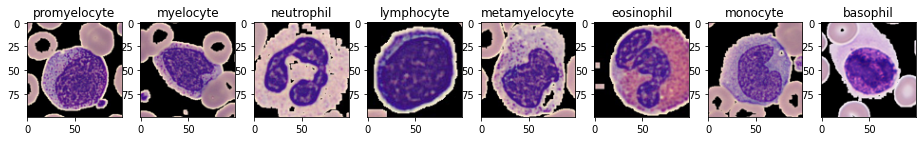

In [24]:
plt.figure(figsize=(20, 15))
for i, digit in enumerate(np.unique(y_target_train), start=1):
    index_ = np.where(y_target_train == digit)[0][0]
    ax = plt.subplot(1, 10, i)
    ax.imshow(x_target_train[index_])
    ax.set_title(rev_index[digit])


In [35]:
from tensorflow.keras.layers import MaxPool2D, Conv2D, Dropout, Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow as tf


from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
# from keras.models import Model
from tensorflow.keras.optimizers import Adam
#from keras.layers import Dense, Flatten, GlobalAveragePooling2D


@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name="grl")

    def call(self, x):
        return grad_reverse(x)


In [36]:
x_source_train.shape[1:]

(100, 100, 3)

In [43]:
def get_adaptable_network(input_shape=x_source_train.shape[1:]):
  #inputs = Input(shape=input_shape)
  frozen = InceptionResNetV2(weights="imagenet", input_shape=input_shape, include_top=False)
  frozen.summary()

  trainable = frozen.output
  trainable = GlobalAveragePooling2D()(trainable)
  trainable = Dense(1536, activation="relu")(trainable)
  #inputs = Input(shape=input_shape)
  # x = Conv2D(32, 5, padding='same', activation='relu', name='conv2d_1')(inputs)
  # x = MaxPool2D(pool_size=2, strides=2, name='max_pooling2d_1')(x)
  # x = Conv2D(48, 5, padding='same', activation='relu', name='conv2d_2')(x)
  # x = MaxPool2D(pool_size=2, strides=2, name='max_pooling2d_2')(x)
  features = Flatten(name='flatten_1')(trainable)
  x = Dense(100, activation='relu', name='dense_digits_1')(features)
  x = Dense(100, activation='relu', name='dense_digits_2')(x)
  digits_classifier = Dense(10, activation="softmax", name="digits_classifier")(x)

  domain_branch = Dense(100, activation="relu", name="dense_domain")(GradReverse()(features))
  domain_classifier = Dense(1, activation="sigmoid", name="domain_classifier")(domain_branch)
  
  return Model(inputs=frozen.input, outputs=[digits_classifier, domain_classifier])

model = get_adaptable_network()
model.summary()


Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2030 (Conv2D)            (None, 49, 49, 32)   864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2030 (Batch (None, 49, 49, 32)   96          conv2d_2030[0][0]                
__________________________________________________________________________________________________
activation_2030 (Activation)    (None, 49, 49, 32)   0           batch_normalization_2030[0][0]   
________________________________________________________________________________

In [44]:
batch_size = 10
epochs = 10

d_source_train = np.ones_like(y_source_train)
d_source_val = np.ones_like(y_source_val)

source_train_generator = tf.data.Dataset.from_tensor_slices(
    (x_source_train, y_source_train, d_source_train)).batch(batch_size)

d_target_train = np.zeros_like(y_target_train)

target_train_generator = tf.data.Dataset.from_tensor_slices(
    (x_target_train, d_target_train)
).batch(batch_size)


In [45]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import Mean, Accuracy
import collections

optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

cce = SparseCategoricalCrossentropy()
bce = BinaryCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=[cce, bce],
    metrics=["accuracy", "accuracy"]
)

count_dummy = 0

history_da = {}
history_da['source_image_loss'] = {}
history_da['source_accuracy'] = {}
history_da['source_domain_loss'] = {}
history_da['target_domain_loss'] = {}

In [ ]:
def train_epoch(source_train_generator, target_train_generator):
    global lambda_factor, global_step, history_da, count_dummy

    # Keras provide helpful classes to monitor various metrics:
    epoch_source_digits = tf.keras.metrics.Mean()
    epoch_source_domains = tf.keras.metrics.Mean()
    epoch_target_domains = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Fetch all trainable variables but those used uniquely for the digits classification:
    variables_but_classifier = list(filter(lambda x: "digits" not in x.name, model.trainable_variables))

    loss_record = collections.defaultdict(list)

    for i, data in enumerate(zip(source_train_generator, target_train_generator)):
        source_data, target_data = data
        # Training digits classifier & domain classifier on source:
        x_source, y_source, d_source = source_data

        with tf.GradientTape() as tape:
            digits_prob, domains_probs = model(x_source)
            digits_loss = cce(y_source, digits_prob)
            domains_loss = bce(d_source, domains_probs)
            source_loss = digits_loss + 0.2 * domains_loss

        gradients = tape.gradient(source_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        epoch_source_digits(digits_loss)
        epoch_source_domains(domains_loss)
        epoch_accuracy(y_source, digits_prob)

        # Training domain classifier on target:
        x_target, d_target = target_data
        with tf.GradientTape() as tape:
            _, domains_probs = model(x_target)
            target_loss = 0.2 * bce(d_target, domains_probs)

        gradients = tape.gradient(target_loss, variables_but_classifier)
        optimizer.apply_gradients(zip(gradients, variables_but_classifier))

        epoch_target_domains(target_loss)

    print("Source image loss = {}, Source Accuracy = {}, Source domain loss = {}, Target domain loss = {}".format(
        epoch_source_digits.result(), epoch_accuracy.result(),
        epoch_source_domains.result(), epoch_target_domains.result()))
    history_da['source_image_loss'][count_dummy] = float(epoch_source_digits.result())
    history_da['source_accuracy'][count_dummy] = float(epoch_accuracy.result())
    history_da['source_domain_loss'][count_dummy] = float(epoch_source_domains.result())
    history_da['target_domain_loss'][count_dummy] = float(epoch_target_domains.result())
    count_dummy += 1


for epoch in range(epochs):
    print("Epoch: {}".format(epoch), end=" ")
    loss_record = train_epoch(source_train_generator, target_train_generator)


Epoch: 0 Source image loss = nan, Source Accuracy = 0.09684684872627258, Source domain loss = nan, Target domain loss = nan
Epoch: 1 Source image loss = nan, Source Accuracy = 0.09009008854627609, Source domain loss = nan, Target domain loss = nan
Epoch: 2 Source image loss = nan, Source Accuracy = 0.09009008854627609, Source domain loss = nan, Target domain loss = nan
Epoch: 3 Source image loss = nan, Source Accuracy = 0.09009008854627609, Source domain loss = nan, Target domain loss = nan
Epoch: 4 Source image loss = nan, Source Accuracy = 0.09009008854627609, Source domain loss = nan, Target domain loss = nan
Epoch: 5 Source image loss = nan, Source Accuracy = 0.09009008854627609, Source domain loss = nan, Target domain loss = nan
Epoch: 6 

In [38]:
# download the model in computer for later use
model.save('DA_SMEAR_to_PBC.h5')

In [39]:
from tensorflow import keras
model = keras.models.load_model('DA_SMEAR_to_PBC.h5',custom_objects={'GradReverse':GradReverse})

In [40]:
import pandas as pd
import json
hist_df = pd.DataFrame(history_da) 
hist_json_file = 'history_da_150e.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [41]:
with open('history_da_150e.json', 'r') as f:
    history_da = json.load(f)
print (len(history_da))

4


In [44]:
source_image_loss_list = []
source_accuracy_list = []
source_domain_loss_list = []
target_domain_loss_list = []
dummy_count = 0
for sd_l, al, sdom_l, td_list in zip(history_da['source_image_loss'],  history_da['source_accuracy'], history_da['source_domain_loss'], history_da['target_domain_loss']):
    source_image_loss_list.append(history_da['source_image_loss'][str(dummy_count)])
    source_accuracy_list.append(history_da['source_accuracy'][str(dummy_count)])
    source_domain_loss_list.append(history_da['source_domain_loss'][str(dummy_count)])
    target_domain_loss_list.append(history_da['target_domain_loss'][str(dummy_count)])
    dummy_count += 1
    source_image_loss_list = []
source_accuracy_list = []
source_domain_loss_list = []
target_domain_loss_list = []
dummy_count = 0
for sd_l, al, sdom_l, td_list in zip(history_da['source_image_loss'],  history_da['source_accuracy'], history_da['source_domain_loss'], history_da['target_domain_loss']):
    source_image_loss_list.append(history_da['source_image_loss'][str(dummy_count)])
    source_accuracy_list.append(history_da['source_accuracy'][str(dummy_count)])
    source_domain_loss_list.append(history_da['source_domain_loss'][str(dummy_count)])
    target_domain_loss_list.append(history_da['target_domain_loss'][str(dummy_count)])
    dummy_count += 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


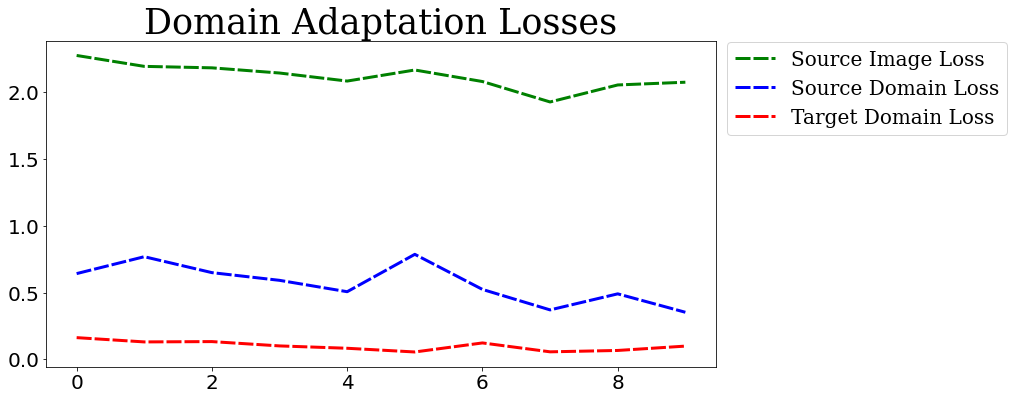

In [47]:
plt.figure(figsize=(12,6))
plt.title('Domain Adaptation Losses', fontsize=35, fontname = 'DejaVu Serif', fontweight = 500)
plt.plot(source_image_loss_list,color='green', linestyle='--', dashes=(5, 1),  linewidth=3.0)
plt.plot(source_domain_loss_list,color='blue', linestyle='-', dashes=(5, 1),  linewidth=3.0)
plt.plot(target_domain_loss_list,color='red', linestyle='-.', dashes=(5, 1),  linewidth=3.0)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

lgd = plt.legend(['Source Image Loss', 'Source Domain Loss', 'Target Domain Loss'],loc="lower right",
          prop={'family':'DejaVu Serif', 'size':20}, bbox_to_anchor=(1.45, 0.68))
plt.savefig('da_plot_losses_history.eps',  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('da_plot_losses_history.png',  bbox_extra_artists=(lgd,), bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


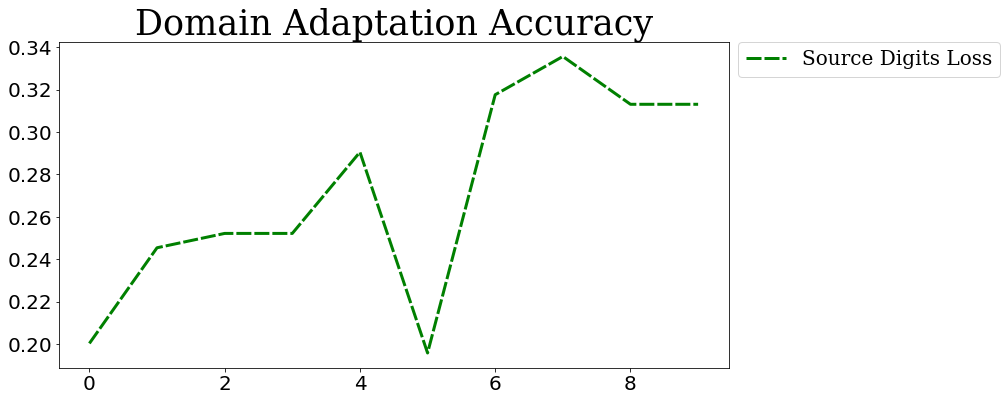

In [48]:
plt.figure(figsize=(12,6))
plt.title('Domain Adaptation Accuracy', fontsize=35, fontname = 'DejaVu Serif', fontweight = 500)
plt.plot(source_accuracy_list,color='green', linestyle='--', dashes=(5, 1),  linewidth=3.0)
# plt.plot(source_domain_loss_list,color='blue', linestyle='-', dashes=(5, 1),  linewidth=3.0)
# plt.plot(target_domain_loss_list,color='red', linestyle='-.', dashes=(5, 1),  linewidth=3.0)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

lgd = plt.legend(['Source Digits Loss', 'Source Domain Loss', 'Target Domain Loss'],loc="lower right",
          prop={'family':'DejaVu Serif', 'size':20}, bbox_to_anchor=(1.42, 0.86))
plt.savefig('da_plot_acc_history.eps',  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('da_plot_acc_history.png',  bbox_extra_artists=(lgd,), bbox_inches='tight')

In [49]:
from tqdm import tqdm

smear_pred_list = []
smear_actual_list = []

for image, y_act in tqdm(zip(x_source_test, y_source_test)):
    smear_pred_list.append(np.argmax(model.predict(image[np.newaxis,...])[0]))
    smear_actual_list.append(y_act)

139it [00:04, 29.27it/s]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


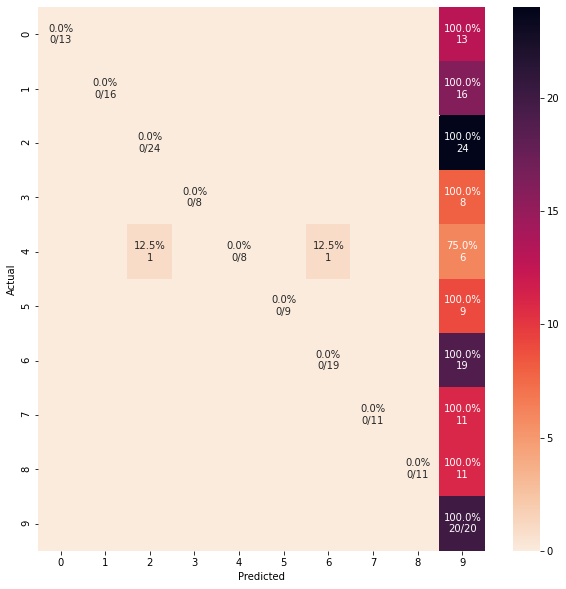

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(smear_actual_list, smear_pred_list)
report = classification_report(smear_actual_list, smear_pred_list)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='rocket_r')
    #plt.savefig(filename)
    plt.savefig('confusion_matrix_smear_da_100e.png')
    plt.savefig('confusion_matrix_smear_da_100e.eps')
    plt.show()

cm_analysis(smear_actual_list, smear_pred_list, [i for i in range(10)] , ymap=None, figsize=(10,10))


# with open('report_smear_da_100e.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     print(report)
#     #sys.stdout = original_stdout # Reset the standard output to its original value

